In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
!pip install albumentations

In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from tensorflow.keras.utils import Sequence

In [30]:
IMAGE_SIZE = 256
NUM_CLASSES = 7
BATCH_SIZE = 4
EPOCHS = 20
LR = 1e-4

In [31]:
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def unet_model(input_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u4 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(bn)
    u4 = layers.concatenate([u4, c4])
    c5 = conv_block(u4, 512)

    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u3 = layers.concatenate([u3, c3])
    c6 = conv_block(u3, 256)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u2 = layers.concatenate([u2, c2])
    c7 = conv_block(u2, 128)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u1 = layers.concatenate([u1, c1])
    c8 = conv_block(u1, 64)

    # Output
    outputs = layers.Conv2D(NUM_CLASSES, 1, activation='softmax')(c8)
    
    return models.Model(inputs, outputs)


In [32]:
class FloodNetGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, transform=None):
        self.image_paths = sorted(os.listdir(image_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        images, masks = [], []

        for image_name in batch_images:
            # Load the image
            img_path = os.path.join(self.image_dir, image_name)
            img = np.array(Image.open(img_path).convert("RGB"))

            # Derive the mask name from image_name
            base_name = os.path.splitext(image_name)[0]
            mask_name = f"{base_name}_lab.png"
            mask_path = os.path.join(self.mask_dir, mask_name)

            # Load the mask
            mask = np.array(Image.open(mask_path))

            # Apply transformation if any
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            images.append(img)
            masks.append(tf.keras.utils.to_categorical(mask, NUM_CLASSES))

        return np.array(images), np.array(masks)


In [37]:
def get_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5)),
    ], is_check_shapes=False)  # disables shape check


In [38]:
train_images = "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/image"
train_masks = "/kaggle/input/aerial-imagery-dataset-floodnet-challenge/FloodNet Challenge - Track 1/Train/Labeled/Flooded/mask"


In [39]:
train_gen = FloodNetGenerator(
    image_dir=train_images,
    mask_dir=train_masks,
    batch_size=BATCH_SIZE,
    transform=get_transforms()
)


In [35]:
def __getitem__(self, idx):
    batch_images = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
    images, masks = [], []

    for image_name in batch_images:
        # Load image
        img_path = os.path.join(self.image_dir, image_name)
        img = np.array(Image.open(img_path).convert("RGB"))

        # Create corresponding mask name with '_lab.png' suffix
        base_name = os.path.splitext(image_name)[0]
        mask_name = f"{base_name}_lab.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load mask safely
        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found for {image_name}")
            continue

        mask = np.array(Image.open(mask_path))

        # Apply transform
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        images.append(img)
        masks.append(tf.keras.utils.to_categorical(mask, NUM_CLASSES))

    return np.array(images), np.array(masks)


In [36]:
from tensorflow.keras.utils import Sequence
import os
import numpy as np
from PIL import Image
import tensorflow as tf

class FloodNetGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, transform=None):
        self.image_paths = sorted(os.listdir(image_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        images, masks = [], []

        for image_name in batch_images:
            # Load image
            img_path = os.path.join(self.image_dir, image_name)
            img = np.array(Image.open(img_path).convert("RGB"))

            # Construct corresponding mask name
            base_name = os.path.splitext(image_name)[0]
            mask_name = f"{base_name}_lab.png"
            mask_path = os.path.join(self.mask_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f"Warning: Mask not found for {image_name}")
                continue

            mask = np.array(Image.open(mask_path))

            # Apply transforms
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            # Clip mask values to valid range
            mask = np.clip(mask, 0, NUM_CLASSES - 1)

            # One-hot encode mask
            masks.append(tf.keras.utils.to_categorical(mask, NUM_CLASSES))
            images.append(img)

        return np.array(images), np.array(masks)


In [40]:
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_gen, epochs=EPOCHS)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 243s 17s/step - accuracy: 0.1913 - loss: 2.0633
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 15s/step - accuracy: 0.3050 - loss: 1.8782
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 202s 15s/step - accuracy: 0.4160 - loss: 1.7051
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 222s 17s/step - accuracy: 0.4706 - loss: 1.5998
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 197s 15s/step - accuracy: 0.4483 - loss: 1.6170
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 15s/step - accuracy: 0.4829 - loss: 1.5122
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 223s 17s/step - accuracy: 0.5368 - loss: 1.4190
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 197s 15s/step - accuracy: 0.5472 - loss: 1.3634
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 197s 15s/step - accuracy: 0.5828 - loss: 1.3025
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 220s 17s/step - accuracy: 0.5819 - loss: 1.2838
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 15s/step - accuracy: 0.5900 - loss: 1.2702
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 196s 15s/step

In [41]:
def visualize_prediction(model, dataset, index=0):
    image, mask = dataset[index]
    image_input = np.expand_dims(image, axis=0)
    pred = model.predict(image_input)
    pred_mask = np.argmax(pred[0], axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[1].imshow(np.argmax(mask, axis=-1), cmap="tab20")
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap="tab20")
    axs[2].set_title("Prediction")
    plt.show()

In [43]:
def visualize_prediction(model, dataset, index_in_batch=0):
    images, masks = dataset[0]  # Get the first batch
    image = images[index_in_batch]
    mask = masks[index_in_batch]

    image_input = np.expand_dims(image, axis=0)
    pred = model.predict(image_input)
    pred_mask = np.argmax(pred[0], axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow((image * 0.5 + 0.5))  # Undo normalization
    axs[0].set_title("Input Image")
    axs[1].imshow(np.argmax(mask, axis=-1), cmap="tab20")
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap="tab20")
    axs[2].set_title("Prediction")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


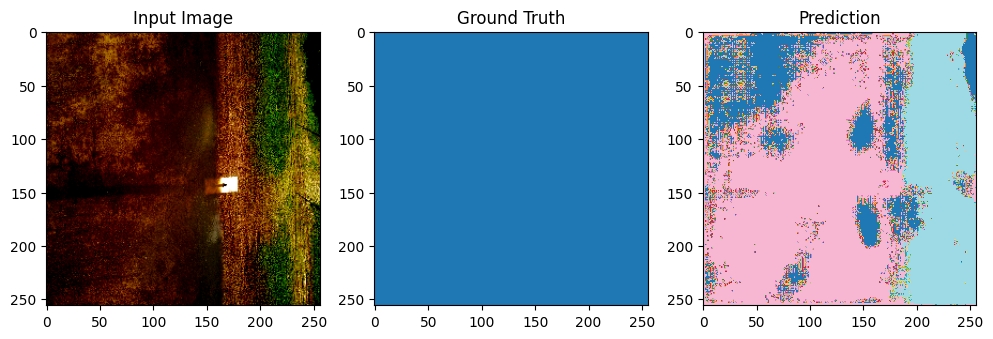

In [44]:
visualize_prediction(model, train_gen, index_in_batch=0)


In [45]:
CLASS_NAMES = [
    "Background",     # 0
    "Building",       # 1
    "Road",           # 2
    "Water",          # 3
    "Vegetation",     # 4
    "Vehicle",        # 5
    "Flooded Building",  # 6
    "Flooded Road",      # 7
    "Flooded Vehicle"    # 8
]


In [48]:
def visualize_prediction(model, dataset, index_in_batch=0):
    images, masks = dataset[2]  # Get a batch
    image = images[index_in_batch]
    mask = masks[index_in_batch]

    image_input = np.expand_dims(image, axis=0)
    pred = model.predict(image_input)
    pred_mask = np.argmax(pred[0], axis=-1)
    gt_mask = np.argmax(mask, axis=-1)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow((image * 0.5 + 0.5))  # Undo normalization if applied
    axs[0].set_title("Input Image")

    axs[1].imshow(gt_mask, cmap="tab20", vmin=0, vmax=len(CLASS_NAMES)-1)
    axs[1].set_title("Ground Truth")

    axs[2].imshow(pred_mask, cmap="tab20", vmin=0, vmax=len(CLASS_NAMES)-1)
    axs[2].set_title("Prediction")

    # Create a colorbar with class names
    cmap = plt.cm.get_cmap("tab20", len(CLASS_NAMES))
    norm = plt.Normalize(vmin=0, vmax=len(CLASS_NAMES)-1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_ticks(np.arange(len(CLASS_NAMES)))
    cbar.set_ticklabels(CLASS_NAMES)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


/tmp/ipykernel_35/630237534.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(CLASS_NAMES))
/tmp/ipykernel_35/630237534.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


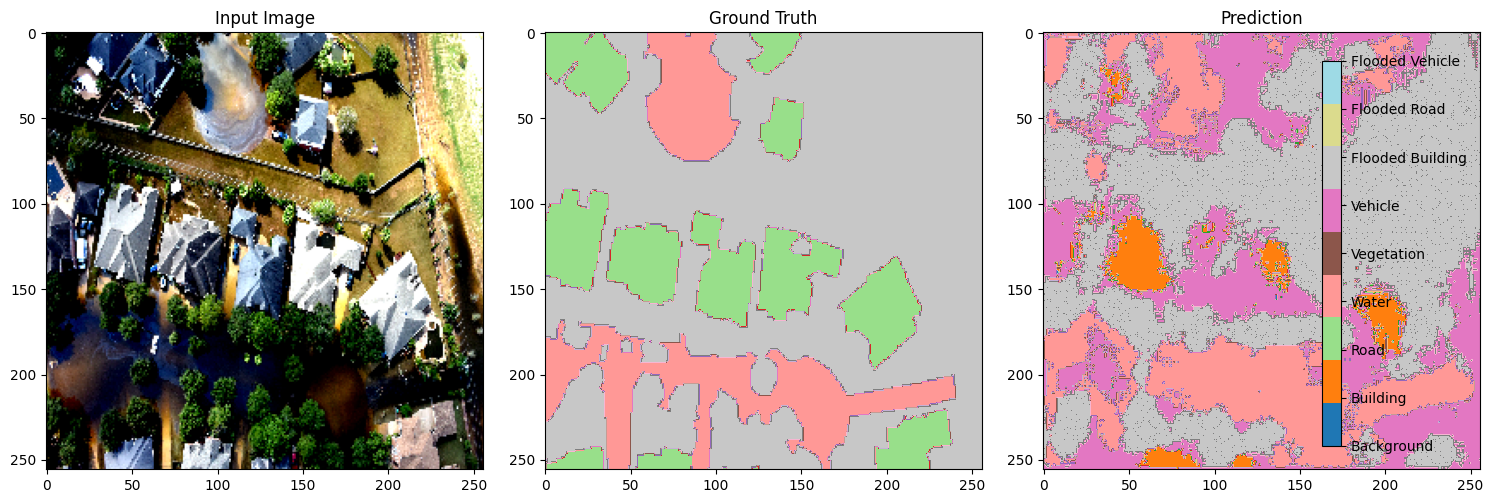

In [49]:
visualize_prediction(model, train_gen, index_in_batch=0)


In [50]:
model.save("floodnet_unet_model.h5")


In [51]:
from IPython.display import FileLink
FileLink("floodnet_unet_model.h5")


/kaggle/working/floodnet_unet_model.h5